# Point cloud classification using Point Transformer

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Point-Transformer-architecture" data-toc-modified-id="Point-Transformer-architecture-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Point Transformer architecture</a></span><ul class="toc-item"><li><span><a href="#Point-Cloud-Serialization" data-toc-modified-id="Point-Cloud-Serialization-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Point Cloud Serialization</a></span></li><li><span><a href="#Attention-Mechanism" data-toc-modified-id="Attention-Mechanism-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Attention Mechanism</a></span></li><li><span><a href="#Positional-Encoding" data-toc-modified-id="Positional-Encoding-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Positional Encoding</a></span></li></ul></li><li><span><a href="#Implementation-in-arcgis.learn" data-toc-modified-id="Implementation-in-arcgis.learn-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Implementation in <code>arcgis.learn</code></a></span><ul class="toc-item"><li><span><a href="#For-advanced-users" data-toc-modified-id="For-advanced-users-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>For advanced users</a></span></li></ul></li><li><span><a href="#Best-practices-for-Point-Transformer-workflow" data-toc-modified-id="Best-practices-for-Point-Transformer-workflow-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Best practices for Point Transformer workflow</a></span></li><li><span><a href="#References" data-toc-modified-id="References-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>References</a></span></li></ul></div>

## Introduction

The `arcgis.learn` module has a state-of-the-art point cloud classification model based on the now popular transformer architecture, called Point Transformer V3 <a href="#references">[1]</a>, which can be used to classify a large number of points in a point cloud dataset. In general, point cloud datasets are gathered using LiDAR sensors, which apply a laser beam to sample the Earth's surface and generate high-precision x, y, and z points. These points, known as "point clouds," are commonly generated through the use of terrestrial and airborne LiDAR.

Point clouds are collections of 3D points that carry the location, measured in x, y, and z coordinates. These points also have some additional information like "GPS timestamps," "intensity," and "number of returns." The intensity represents the returning strength from the laser pulse that scanned the area, and the number of returns shows how many times a given pulse returned. LiDAR data can also be fused with RGB (red, green, and blue) bands, derived from imagery taken simultaneously with the LiDAR survey.

Point cloud classification is based on the type of object that reflected the laser pulse. For example, a point that reflects off the ground is classified into the ground category. LiDAR points can be classified into different categories like buildings, trees, highways, water, etc. These different classes have numeric codes assigned to them.

<p align="center">
<center>
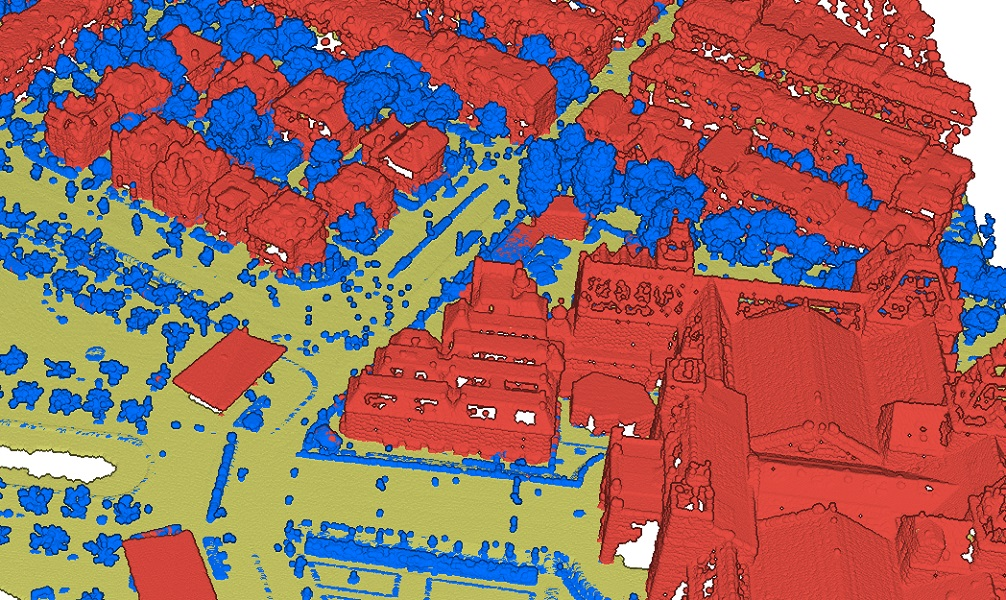
</center>
</p>
<br>
<center>Figure 1. Visualization of point cloud dataset, with classes represented by different colors.</center>

Point cloud classification is a task where each point in the point cloud is assigned a label, representing a real-world entity (see Figure 1). And similar to how it's done in traditional methods, for deep learning, the point cloud classification process involves training, where the neural network learns from an already classified (labeled) point cloud dataset, where each point has a unique class code. These class codes are used to represent the features that we want the neural network to recognize.

When it comes to classifying point clouds, deep learning and neural networks are a great choice since they offer a scalable and efficient architecture. They have enormous potential to make manual or semi-assisted classification modes of point clouds a thing of the past. With that in mind, we can take a closer look at the Point Transformer V3 model included in `arcgis.learn` and how it can be used for point cloud classification.

Point Transformer V3 (PTv3) is a new and improved point transformer model that builds upon the successes of its predecessors, PTv1 and PTv2. It's designed with a focus on simplicity, efficiency, and performance. One of the key improvements in PTv3 over PTv1 is the introduction of grouped vector attention (GVA). This mechanism allows for efficient information exchange within the model, leading to better performance. PTv3 also boasts a receptive field that is 64 times wider than PTv1, enabling it to capture a broader context of the point cloud data. <a href="#references">[1]</a> It replaces the computationally expensive KNN neighbor search with a more efficient serialized neighbor mapping. The complex attention patch interaction mechanisms of PTv2 are also simplified in PTv3, further enhancing efficiency. Moreover, PTv3 replaces relative positional encoding with a prepositive sparse convolutional layer, contributing to its overall simplicity and performance.

It's worth noting that PTv3's strength also lies in its ability to effectively capture local context and structural information within point clouds. This is crucial for various 3D understanding tasks such as classification, segmentation, and object detection. <a href="#references">[1]</a>


## Point Transformer architecture

PTv3 follows a U-Net framework with four stages of encoders and decoders. It simplifies the block structure using a pre-norm structure and layer normalization. It employs grid pooling for efficient downsampling. The three major aspects of PTv3 are as follows:

1. **Serialization:** Point transformer introduces point cloud serialization, transforming the data into a structured format for efficient processing. It utilizes space-filling curves like the Z-order curve and the Hilbert curve to preserve spatial proximity.

2. **Attention Mechanism:** PTv3 employs a simplified attention mechanism that is tailored for serialized point clouds. It utilizes a patch attention mechanism, grouping points into non-overlapping patches for localized processing.

3. **Positional Encoding:** PTv3 replaces the computationally expensive relative positional encoding with a simpler and more efficient conditional positional encoding (CPE). This is implemented by a sparse convolutional layer.

### Point Cloud Serialization

<p align="center">
<center>
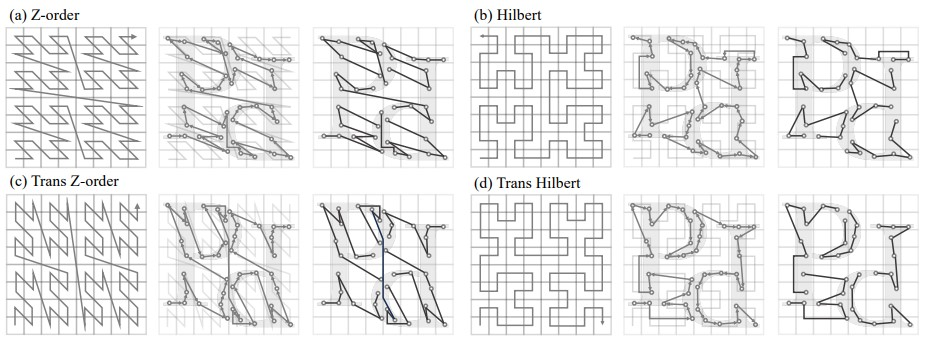
</center>
</p>
<br>
<center>Figure 2. Four point cloud serialization patterns are shown, each with a triplet visualization. The triplets show the serialization curve, sorting order, and grouped patches for local attention. <a href="#references">[1]</a>. </center>

Unlike images, which have a natural 2D structure, point clouds are inherently unordered. Point cloud serialization is a crucial step in Point Transformer V3 (PTv3) that transforms the inherently unordered point cloud data into a structured format. This structured format enables the model to process the data more efficiently and leverage the advantages of sequence processing techniques commonly used in natural language processing.

The serialization process utilizes space-filling curves, such as the Z-order curve and the Hilbert curve. These curves traverse the 3D space in a way that preserves spatial locality, meaning that points close together in 3D space are also close together in the serialized sequence (see Figure 2).

PTv3 introduces a novel concept of shifting across different serialization patterns. This shifting allows the attention mechanism (explained later) to capture a wider range of spatial relationships and contexts within the point cloud, leading to improved accuracy and generalization capabilities.

### Attention Mechanism

PTv3 employs a simplified attention mechanism that is tailored for serialized point clouds. It utilizes a patch attention mechanism, which groups points into non-overlapping patches. Attention is then computed within each patch, allowing for localized processing and reducing computational complexity. This approach contrasts with previous Point Transformer versions that used more computationally expensive global attention mechanisms.

This patch attention mechanism is further enhanced by various patch interaction designs, such as:

- Shift Dilation: Staggering patch grouping by a specific step to extend the receptive field.
- Shift Patch: Shifting the positions of patches across the serialized point cloud, similar to the shift-window strategy in image transformers.
- Shift Order: Dynamically varying the serialized order of the point cloud data between attention blocks to prevent overfitting to a single pattern.
- Shuffle Order: Randomizing the sequence of serialization patterns to further enhance the receptive field of each attention layer.

These designs contribute to the efficiency and effectiveness of the attention mechanism in capturing complex relationships within the point cloud data.

### Positional Encoding

Accurate positional information is crucial for point cloud understanding. PTv3 replaces the computationally expensive relative positional encoding (RPE) used in earlier versions with a simpler and more efficient approach. It utilizes a conditional positional encoding (CPE) implemented by a sparse convolutional layer.This CPE effectively captures positional information while minimizing computational overhead. The sparse convolutional layer is prepended before the attention layer with a skip connection, further enhancing the efficiency of the positional encoding process. The changes in positional encoding contribute to the overall efficiency and scalability of PTv3, enabling it to handle large-scale point cloud data with improved speed and accuracy.

## Implementation in `arcgis.learn`

When training a Point Transformer V3 model (`PTv3Seg`) using `arcgis.learn`, the raw point cloud dataset in LAS files is first converted into blocks of points, containing a specific number of points along with their class codes.

<p align="center">
<center>
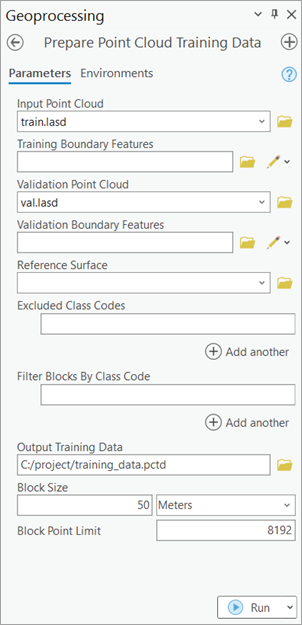
</center>
</p>
<br>
<center>Figure 3. <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/prepare-point-cloud-training-data.htm" target="_blank">Prepare Point Cloud Training Data</a> tool in ArcGIS Pro.</center>

For this step of exporting the data into an intermediate format, use <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/prepare-point-cloud-training-data.htm" target="_blank">Prepare Point Cloud Training Data</a> tool, in the <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/an-overview-of-the-3d-analyst-toolbox.htm" target="_blank">3D Analyst extension</a> (see Figure 3).

These exported blocks are used to create a `data bunch` object that is passed into the `PTv3Seg` model for training.

```python
output_path=r'C:/project/training_data.pctd'
data = prepare_data(output_path, dataset_type='PointCloud', batch_size=2)
rl = PTv3Seg(data)
rl.fit(20)
```
After training the `PTv3Seg` model, `compute_precision_recall()` method can be used to compute, per-class metrics (precision, recall, and f1-score) with respect to validation data. And `save()` method can be used to save the model.

<p align="center">
<center>
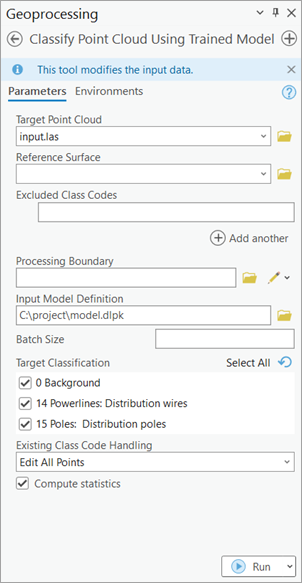
</center>
</p>
<center>Figure 4. <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/classify-point-cloud-using-trained-model.htm" target="_blank">Classify Points Using Trained Model</a> tool. </center>

For inferencing, use <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/classify-point-cloud-using-trained-model.htm" target="_blank">Classify Points Using Trained Model</a> tool, in the <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/an-overview-of-the-3d-analyst-toolbox.htm" target="_blank">3D Analyst extension</a> (see Figure 4).

Main features available during the inferencing step:
       
- _Target classification:_ selective classification for flexibility and control in trained model's predictions.


- _Preserving specific classes in input data from modification:_ this can be used for updating old datasets and for noise control in model's prediction.

Detailed tool references and resources for point cloud classification using deep learning in ArcGIS Pro can be found <a href="https://pro.arcgis.com/en/pro-app/latest/help/data/las-dataset/introduction-to-deep-learning-and-point-clouds.htm" target="_blank">here</a>.

### For advanced users 

We can also specify, additional parameters that directly affect the properties of the architecture itself, this can be done while initializing the `PTv3` model, by using the following parameters.

- `sub_sampling_ratio` Sampling ratio of points in each layer.


- `seq_len` Sequence length for transformer.


- `voxel_size` Defines the size of voxels in meters for a block.


A typical usage with respect to API looks like:

For Point Cloud Classification:
```python
pt = PTv3Seg(data=data, 
             sub_sampling_ratio=2,
             seq_len=1200,
                      
            )
```

For 3D Object Detection:

```python
ptdet = PTv3Det(data=data)
```

## Best practices for Point Transformer workflow

The following tips and best practices can be used while using Point Transformer V3:

- The <a href="https://pro.arcgis.com/en/pro-app/latest/help/data/las-dataset/introduction-to-deep-learning-and-point-clouds.htm" target="_blank">3D deep learning tools</a> in the <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/an-overview-of-the-3d-analyst-toolbox.htm" target="_blank">3D Analyst extension</a>, takes care of the coordinate system, and related discrepancies, automatically. So, one can train a model using ArcGIS Pro on a dataset with a metric coordinate system, then use that trained model on a dataset with any other coordinate system, and vice-versa without any need for re-projection.

- High-quality labeled data will result in a better-trained model. For generalization and robustness of the trained model, significant diversity or variety should be present in the training data, in terms of geography, building architectures, terrains, object-related variations, etc.

- If the object of interest is significantly larger or smaller in size than the default value of `Block Size`, then a better value can be used for improving the results further. Like, for a dataset in a metric coordinate system, a _'warehouse'_ won't fit in a '50 meter' x '50 meter' `Block Size`, hence the `Block Size` can be increased in this case. 

- Through a series of experiments, it was found that an additional one or two `extra_features` apart from X, Y, and Z usually works best, in most cases. Over usage of 'extra attributes' for model training might reduce generalization, i.e. _'how generic the trained model will be'_. 

- Deciding which 'extra attributes' to consider, depends upon the properties of the object of interest, the nature of noise, sensor-specific attributes, etc. 

- It is recommended to filter or withheld points that belong to the 'high noise' class from the dataset.

- If the training and validation dataset is very large and each epoch is taking a lot of time to complete, then `iters_per_epoch` can be used to see the epoch/training table quickly by reducing the time taken for the completion of an epoch. This is achieved by a random selection/filtering of fewer batches, governed by the user-provided value of `iters_per_epoch`. So in each epoch, the model is exposed to a lesser number of randomly selected batches, this results in faster completion of an epoch, but it can lead to more numbers of epochs before the model converges. 

- `mask_class` functionality in `show_results()` can be used for analyzing any inter-class noises present in the validation output. This can be used to understand which classes need more diversity in training data or need an increase in its number of labeled points _(See Figure 5)_.


<p align="center"><center><img src="../../static/img/pointcnn_guide_gif_1.gif" /></center></p>

<center>Figure 5. Class-based masking of points, to understand the nature of noise in the prediction.</center>

- The default value of `max_display_point` in `show_batch()` and `show_results()` is set to '20000', keeping the rendering-related browser limitation in mind, which can occur for very dense point clouds. This value can be increased if needed, for detailed visualization, within the browser itself. 

- `Target Classification` and `Class Preservation` in <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/classify-point-cloud-using-trained-model.htm" target="_blank">Classify Points Using Trained Model</a> tool, can be used in conjunction to combine the knowledge of multiple trained models for a single scene. 

- Parameters like, `classes_of_interest` and `min_points` are especially useful when training a model for SfM or mobile/terrestrial point clouds. In specific scenarios when the 'training data' is not small, these features can be very useful in speeding up the 'training time', improving the convergence during training, and addressing the class imbalance up to some extent.

- Fine-tuning a pretrained model is only preferred if the 'object of interest' is either same or similar, else it is not beneficial. Otherwise, fine-tuning a pretrained model can save cost, time, and compute resources while providing better accuracy/quality in results.

- Class codes can be given a meaningful name, using `class_mapping`. The names of the class codes are saved inside the model, which is automatically retrieved by <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/classify-point-cloud-using-trained-model.htm" target="_blank">Classify Points Using Trained Model</a> tool and <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/train-point-cloud-classification-model.htm" target="_blank">Train Point Cloud Classification Model</a> tool, when a trained model is loaded.

- For fine-tuning a model with default architecture settings;  'Class Structure', 'Extra Attributes', and 'Block Point Limit' should match between the pretrained model and the exported 'training data'.

## References


[1] Wu, X., Jiang, L., Wang, P.-S., Liu, Z., Liu, X., Qiao, Y., Ouyang, W., He, T., & Zhao, H. (2023). Point Transformer V3: Simpler, Faster, Stronger. http://arxiv.org/abs/2312.10035